In [29]:
import itertools
import re
import math
import json

import numba
import more_itertools

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from copy import deepcopy
from functools import lru_cache
from collections import Counter, defaultdict
from more_itertools import windowed

from lib import level_a, level_b, level_ab

In [2]:
@level_ab(1, apply=int, test=("199\n200\n208\n210\n200\n207\n240\n269\n260\n263", 7, 5))
def solve(num, level):
    if level:
        num = num[2:] + num[1:-1] + num[:-2]  # 3-frame-windowing
    return ( ( num[1:] - num[:-1] ) > 0).sum()

Part a already solved with same answer: 1184
Part b already solved with same answer: 1158


In [3]:
@level_ab(2, test=('forward 5\ndown 5\nforward 8\nup 3\ndown 8\nforward 2', 150, 900))
def solve(lines, level):
    dirs = {"forward": 1j, "up": 1, "down": -1}
    pos = aim = 0
    for line in lines:
        dire, dist = line.split()
        dire, dist = dirs[dire], int(dist)
        if level:
            if dire.real:
                aim += dist * dire
            else:
                pos += dist + dist * aim * dire
        else:
            pos += dire * dist
    return np.absolute([pos.real, pos.imag]).prod(dtype=int)

Part a already solved with same answer: 1694130
Part b already solved with same answer: 1698850445


In [4]:
def inner(arr, level):
    for pos in range(arr.shape[1]):
        curr = arr[:,pos].mean(axis=0) >= 0.5  # unlike np.round, round UP on 0.5
        curr = int(curr == level)  # invert for epsilon
        arr = arr[arr[:,pos] == curr]  # filter array at position pos
        if len(arr) == 1:
            return arr[0]

@level_ab(3, apply=lambda line: [int(i) for i in line], test=('00100\n11110\n10110\n10111\n10101\n01111\n00111\n11100\n10000\n11001\n00010\n01010', 198, 230))
def solve(num, level):
    bin2dec = lambda x: int("".join(map(str, x)), 2)

    if level:
        return bin2dec(inner(num, 1)) * bin2dec(inner(num, 0))
    else:
        gamma = num.mean(axis=0).round().astype(int)
        epsilon = 1 - gamma  # boolean invert
        return bin2dec(gamma) * bin2dec(epsilon)

Part a already solved with same answer: 2743844
Part b already solved with same answer: 6677951


In [5]:
@level_ab(4, sep="\n\n", test=('7,4,9,5,11,17,23,2,0,14,21,24,10,16,13,6,15,25,12,22,18,20,8,19,3,26,1\n\n22 13 17 11  0\n 8  2 23  4 24\n21  9 14 16  7\n 6 10  3 18  5\n 1 12 20 15 19\n\n 3 15  0  2 22\n 9 18 13 17  5\n19  8  7 25 23\n20 11 10 24  4\n14 21 16 12  6\n\n14 21 17 24  4\n10 16 15  9 19\n18  8 23 26 20\n22 11 13  6  5\n 2  0 12  3  7', 4512, 1924))
def solve(chunks, level):
    numbers, *fields = chunks
    fields = [np.genfromtxt(field.splitlines(), dtype=int) for field in fields]
    winners = set()
    for number in map(int, numbers.split(",")):
        for i in range(len(fields)):
            field = fields[i]
            fields[i][field==number] = -1
            mask = fields[i] == -1
            if (mask.sum(axis=0) == 5).any() or (mask.sum(axis=1) == 5).any():
                winners.add(i)
                if not level or len(winners) == len(fields):
                    return number * field[~mask].sum()

Part a already solved with same answer: 60368
Part b already solved with same answer: 17435


In [6]:
@level_ab(5, test=('0,9 -> 5,9\n8,0 -> 0,8\n9,4 -> 3,4\n2,2 -> 2,1\n7,0 -> 7,4\n6,4 -> 2,0\n0,9 -> 2,9\n3,4 -> 1,4\n0,0 -> 8,8\n5,5 -> 8,2', 5, 12))
def solve(lines, level):
    field = defaultdict(int)
    for line in lines:
        start, end = [complex(*[int(i) for i in part.split(",")]) for part in line.split(" -> ")]
        dist = end - start
        dlen = int(max(abs(dist.real), abs(dist.imag)))
        if not dist.real or not dist.imag or (level and dist.real / dist.imag % 1 == 0):
            for d in range(dlen+1):
                field[start + (dist/dlen) * d] += 1
    return sum([v > 1 for v in field.values()])

Part a already solved with same answer: 5835
Part b already solved with same answer: 17013


In [7]:
@level_ab(6, sep=",", apply=int, test=("3,4,3,1,2", 5934, 26984457539))
def solve(num, level):
    cnt = Counter(num)
    for i in range(256 if level else 80):
        cnt = Counter({k-1: v for k, v in cnt.items()})
        cnt[6] += cnt.get(-1, 0)
        cnt[8] += cnt.get(-1, 0)
        cnt[-1] = 0
    return sum(cnt.values())

Part a already solved with same answer: 350149
Part b already solved with same answer: 1590327954513


In [8]:
# alt solution with matrix kernel power
def solve_np(data, days):
    cnt = np.bincount(data, minlength=9)
    kernel = np.pad(np.identity(8, dtype=np.int64), ((1, 0), (0, 1)))  # discrete projection: t_x -> t_(x+1) = 1 -> 0, 2 -> 1
    kernel[0, [6,8]] = 1  # extra projection: 0 -> 6, 8
    kernel = np.linalg.matrix_power(kernel.astype(object), days)  # astype object to use python builtin unlimited size ints, works fine with a million
    return (cnt @ kernel).sum()

# len(str(solve_np((3,4,3,1,2), 2**20)))  # 39674

In [9]:
@level_ab(7, sep=",", apply=int, test=("16,1,2,0,4,2,7,1,2,14", 37, 168))
def solve(num, level):
    distance = lambda n: n*(n+1)//2 if level else n
    return min([distance(np.abs(num-i)).sum()
                for i in range(min(num), max(num))])

Part a already solved with same answer: 329389
Part b already solved with same answer: 86397080


In [10]:
@level_ab(8, apply=lambda part: (part.split(" ") for part in part.split(" | ")), test=('be cfbegad cbdgef fgaecd cgeb fdcge agebfd fecdb fabcd edb | fdgacbe cefdb cefbgd gcbe\nedbfga begcd cbg gc gcadebf fbgde acbgfd abcde gfcbed gfec | fcgedb cgb dgebacf gc\nfgaebd cg bdaec gdafb agbcfd gdcbef bgcad gfac gcb cdgabef | cg cg fdcagb cbg\nfbegcd cbd adcefb dageb afcb bc aefdc ecdab fgdeca fcdbega | efabcd cedba gadfec cb\naecbfdg fbg gf bafeg dbefa fcge gcbea fcaegb dgceab fcbdga | gecf egdcabf bgf bfgea\nfgeab ca afcebg bdacfeg cfaedg gcfdb baec bfadeg bafgc acf | gebdcfa ecba ca fadegcb\ndbcfg fgd bdegcaf fgec aegbdf ecdfab fbedc dacgb gdcebf gf | cefg dcbef fcge gbcadfe\nbdfegc cbegaf gecbf dfcage bdacg ed bedf ced adcbefg gebcd | ed bcgafe cdgba cbgef\negadfb cdbfeg cegd fecab cgb gbdefca cg fgcdab egfdb bfceg | gbdfcae bgc cg cgb\ngcafb gcf dcaebfg ecagb gf abcdeg gaef cafbge fdbac fegbdc | fgae cfgab fg bagce', 26, 61229))
def solve(lines, level):
    total = 0
    len2num = {2: 1, 3: 7, 4: 4, 7: 8}
    for inp, out in lines:
        d = {len2num.get(len(k), k): frozenset(k) for k in set(inp + out)}  # mapping: digit to set
        set2num = {v: (3 if d[7] < v else 5 if d[4]-d[7] < v else 2) if len(v) == 5 else    # case: len5
                      (9 if d[4] < v else 0 if d[1]      < v else 6) if len(v) == 6 else k  # case: len6 and others
                   for k, v in d.items()}  # set2digit
        total += int("".join(str(set2num[frozenset(letter)]) for letter in out)) if level else \
                 len([s for s in out if len(s) in len2num.keys()])  # digits 1, 4, 7, 8
    return total

Part a already solved with same answer: 421
Part b already solved with same answer: 986163


In [11]:
neighbors = lambda i, j: [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

def watershed_size(d, i, j):
    d[i,j] = 9
    return 1 + sum([watershed_size(d, *n) for n in neighbors(i,j) if d[n] != 9])

@level_ab(9, test=("2199943210\n3987894921\n9856789892\n8767896789\n9899965678", 15, 1134))
def solve(lines, level):
    data = np.pad([[int(i) for i in line] for line in lines], (1, 1), constant_values=9)  # pad corner with 9
    h, w = data.shape
    basins = [watershed_size(data, i, j) if level else                  # recursive watershedding size algo
              data[i][j] + 1                                            # risk level = min peak + 1
              for i in range(1, h-1) for j in range(1, w-1)             # exclude padding
              if all([data[i][j] < data[n] for n in neighbors(i, j)])]  # all neighbors must be smaller
    return np.prod(sorted(basins)[-3:]) if level else sum(basins)

Part a already solved with same answer: 498
Part b already solved with same answer: 1071000


In [12]:
score0 = {")": 3, "]": 57, "}": 1197, ">": 25137}
score1 = {")": 1, "]": 2, "}": 3, ">": 4}
close = {")": "(", "]": "[", "}": "{", ">": "<"}
score1 = {v: score1[k] for k, v in close.items()}

@level_ab(10, test=('[({(<(())[]>[[{[]{<()<>>\n[(()[<>])]({[<{<<[]>>(\n{([(<{}[<>[]}>{[]{[(<()>\n(((({<>}<{<{<>}{[]{[]{}\n[[<[([]))<([[{}[[()]]]\n[{[{({}]{}}([{[{{{}}([]\n{<[[]]>}<{[{[{[]{()[[[]\n[<(<(<(<{}))><([]([]()\n<{([([[(<>()){}]>(<<{{\n<{([{{}}[<[[[<>{}]]]>[]]', 26397, 288957))
def solve(lines, level):
    total = 0
    scores = []
    for line in lines:
        opened = []
        for char in line:
            if char in close:
                if opened and opened[-1] == close[char]:
                    opened.pop(-1)
                else:  # error case: no closing tag on stack
                    total += score0[char]
                    break
            else:
                opened += char
        else:  # if no break was taken
            subtotal = 0
            for c in reversed(opened):
                subtotal = subtotal * 5 + score1[c]
            scores.append(subtotal)
    return sorted(scores)[len(scores)//2] if level else total

Part a already solved with same answer: 318099
Part b already solved with same answer: 2389738699


In [13]:
@level_ab(11, test=('5483143223\n2745854711\n5264556173\n6141336146\n6357385478\n4167524645\n2176841721\n6882881134\n4846848554\n5283751526', 1656, 195))
def solve(lines, level):
    data = np.pad([[int(i) for i in line] for line in lines], (1, 1), constant_values=-99999)
    total = 0

    for step in range(99999 if level else 100):
        data += 1  # increase every field value by 1
        flashed_this_step = set()
        while data[data > 9].any():  # inner step has to be redone to propagate it
            for x, y in zip(*np.where(data > 9)):  # for all values > 9
                data[x-1:x+2, y-1:y+2] += 1  # increase adjacent values +1
                flashed_this_step.add((x,y))
            for x, y in flashed_this_step:  # reset after every sub-step, so it can't re-flash as the max number of neigh is 9
                data[x,y] = 0
        total += len(flashed_this_step)
        if level and len(flashed_this_step) == 100:
            return step+1
    return total

Part a already solved with same answer: 1640
Part b already solved with same answer: 312


In [14]:
def all_paths(g, curr, visited, all_visited, can_twice=True):
    visited += tuple([curr])
    if curr == "end":
        all_visited.add(visited)
        return
    for n in nx.neighbors(g, curr):
        if n.isupper() or n not in visited:
            all_paths(g, n, visited, all_visited, can_twice)
        elif can_twice and n != "start":
            all_paths(g, n, visited, all_visited, False)
    return all_visited

@level_ab(12, test=('start-A\nstart-b\nA-c\nA-b\nb-d\nA-end\nb-end', 10, 36))
def solve(lines, level):
    g = nx.Graph([line.split("-") for line in lines])
    res = all_paths(g, "start", tuple(), set(), can_twice=level)
    return len(res)

Part a already solved with same answer: 3292
Part b already solved with same answer: 89592


Part a already solved with same answer: 827


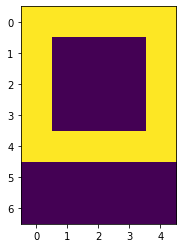

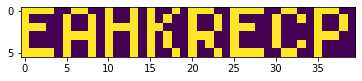

Part b already solved with same answer: EAHKRECP


In [15]:
@level_ab(13, sep="\n\n", test=('6,10\n0,14\n9,10\n0,3\n10,4\n4,11\n6,0\n6,12\n4,1\n0,13\n10,12\n3,4\n3,0\n8,4\n1,10\n2,14\n8,10\n9,0\n\nfold along y=7\nfold along x=5', 17, "EAHKRECP"))
def solve(lines, level):
    data, fold = lines
    d = np.array([[int(i) for i in d.split(",")] for d in data.split("\n")])
    field = np.zeros([np.max(d)+1]*2, dtype=bool)
    field[tuple(d.T)] = True
    for f in fold.split("\n"):
        direction, dist = f.split("=")
        direction, dist = direction[-1:], int(dist)

        field = field.T if direction == "y" else field  # y-case: just do it mirrored
        field = field[:dist] | field[dist+1:][:dist][::-1]  # cut field, and OR it with other field reversed
        field = field.T if direction == "y" else field

        if not level: return field.sum()   # level1: return after first fold
    plt.imshow(field.T)
    plt.show()
    return "EAHKRECP"

In [16]:
def step(cp, rules):
    nc = Counter()
    for (a, b), cnt in cp.items():
        m = rules.get(a+b, "")  # if not found, get empty -> new keys will be len(1), case for letter-count
        nc[a + m] += cnt
        nc[m + b] += cnt
    return nc

@level_ab(14, test=('NNCB\n\nCH -> B\nHH -> N\nCB -> H\nNH -> C\nHB -> C\nHC -> B\nHN -> C\nNN -> C\nBH -> H\nNC -> B\nNB -> B\nBN -> B\nBB -> N\nBC -> B\nCC -> N\nCN -> C', 1588, 2188189693529))
def solve(lines, level):
    d = lines[0]
    rules = dict([rule.split(" -> ") for rule in lines[2:]])  # lookup dict: first, second -> insert
    pair_cnt = Counter([d[i:i+2] for i in range(len(d)-1)])  # count pairs
    for j in range(40 if level else 10):
        pair_cnt = step(pair_cnt, rules)
    letter_cnt = step(pair_cnt, {})
    letter_cnt[d[0]] += 1  # corner case: first and last char stay const and appear 1x more
    letter_cnt[d[-1]] += 1
    return (max(letter_cnt.values()) - min(letter_cnt.values())) // 2

Part a already solved with same answer: 3230
Part b already solved with same answer: 3542388214529


In [17]:
@level_ab(15, test=('1163751742\n1381373672\n2136511328\n3694931569\n7463417111\n1319128137\n1359912421\n3125421639\n1293138521\n2311944581', 40, 315))
def solve(lines, level):
    data = np.array([[int(i) for i in line] for line in lines])
    if level:
        dx, dy = data.shape
        data = np.tile(data, (5, 5))
        for i, j in np.ndindex(5, 5):
            data[i*dx:i*dx+dx, j*dy:j*dy+dy] += i + j
        data = (data - 1 ) % 9 + 1  # 10 becomes 1

    g = nx.DiGraph(((a, b), (x,y), {"weight": w})
                   for (x, y), w in np.ndenumerate(data)
                   for a, b in [(x-1, y), (x, y-1), (x+1, y), (x, y+1)]
                   if a in range(len(data)) and b in range(len(data[0])))
    dx, dy = data.shape
    return nx.dijkstra_path_length(g, (0, 0), (dx-1, dy-1))

Part a already solved with same answer: 602
Part b already solved with same answer: 2935


In [18]:
from bitstring import BitStream
from operator import gt, lt, eq

OPERATORS = {0: sum, 1: np.prod, 2: min, 3: max, 5: lambda a: gt(*a), 6: lambda a: lt(*a), 7: lambda a: eq(*a)}
LITERAL_TYPEID = 4; CHUNK_SIZE = 4; LEN_CNT = 11; LEN_BITS = 15

def parse(packet: BitStream):
    version = packet.read(3).uint
    typeid = packet.read(3).uint

    if typeid == LITERAL_TYPEID:
        val = 0
        read_more = True
        while read_more:  # read chunks of 1+4 = 5 until a chunk starts with 1
            read_more = packet.read(1)
            val = packet.read(CHUNK_SIZE).uint + (val << CHUNK_SIZE)
    else:  # operator
        val = []  # list of sub-packet-values
        length_type = packet.read(1)  # 0 = bits, 1 = sub-packtets
        length = packet.read(LEN_CNT if length_type else LEN_BITS).uint

        while length > 0:  # > 0 to prevent over-reading in bits-mode
            before = packet.pos
            version_, val_ = parse(packet)

            # substract 1 packet cnt if 1, length_type, else substract sub packet length
            length -= 1 if length_type else packet.pos - before  # after - before = consumed length
            version += version_  # sum up versions for part a
            val.append(val_)  # collect values for part b
        assert length == 0  # sanity check

        val = int(OPERATORS[typeid](val))  # apply operator with typeid to values. int to turn bool into int
    return version, val

# manual tests, as the annotation doesn't allow multiple tests per level with different values
for h, e in zip(["D2FE28","38006F45291200","EE00D40C823060","8A004A801A8002F478","620080001611562C8802118E34","C0015000016115A2E0802F182340","A0016C880162017C3686B18A3D4780"],
                [6, 9, 14, 16, 12, 23, 31]):  # version sums
    assert parse(BitStream(hex=h))[0] == e

for h, e in zip(["C200B40A82", "04005AC33890", "880086C3E88112", "CE00C43D881120", "D8005AC2A8F0", "F600BC2D8F", "9C005AC2F8F0", "9C0141080250320F1802104A08"],
                [3, 54, 7, 9, 1, 0, 0, 1]):  # expected values
    assert parse(BitStream(hex=h))[1] == e

@level_ab(16)
def solve(lines, level):
    return parse(BitStream(hex=lines[0]))[level]

Part a already solved with same answer: 886
Part b already solved with same answer: 184487454837


In [ ]:
@numba.njit()
def simulate(x1, x2, y1, y2, limit=200):
    res = []
    for idx in numba.prange(1, limit):
        for idy in range(-limit, limit):
            dx, dy = idx, idy  # create copy, to not modify the loop var
            x, y, y_max = 0, 0, 0
            while x < x2 and y > y1 and not (dx == 0 and not (x1 <= x <= x2)):
                x += dx
                y += dy
                y_max = max(y_max, y)
                dx -= np.sign(dx)
                dy -= 1
                if x1 <= x <= x2 and y1 <= y <= y2:
                    res.append(y_max)
                    break
    return res

@level_ab(17, test=("""target area: x=20..30, y=-10..-5""", 45, 112))
def solve(lines, level):
    highpoints = list(simulate(*map(int, re.findall("-?\\d+", lines[0]))))
    return len(highpoints) if level else max(highpoints)

In [87]:
def magnitude(d):
    if type(d) == int:
        return d
    return magnitude(d[0]) * 3 + magnitude(d[1]) * 2


def add(d, side, num, switch_side=True):
    if type(d[side]) == int:
        d[side] += num
    else:
        add(d[side], side != switch_side , num, switch_side=False)

        
def split(parent):
    for kid in parent:
        if type(kid) == int and kid > 9:
            parent[parent.index(kid)] = [floor(kid/2), ceil(kid/2)]
            return True
        elif type(kid) == list:
            if split(kid): return True
    

def explode(d0, parents = ()):
    sublists = lambda li: [sub for sub in li if type(sub) == list]
    for d1 in sublists(d0):
        for d2 in sublists(d1):
            for d3 in sublists(d2):
                for d4 in sublists(d3):
                    for side in [0, 1]:
                        for parent, kid in windowed((d4, d3, d2, d1, d0), 2):
                            if kid.index(parent) == int(not side):
                                add(kid, side, d4[side])
                                break

                    d3[d3.index(d4)] = 0
                    return True
    

def run(lines, test=True):
    lines = deepcopy(lines)
    curr = lines[0]
    for line in lines[1:]:
        curr = [curr] + [line]
        while explode(curr) or split(curr): pass
    return magnitude(curr)


for method, inp, expected in [
    [explode, [[[[[9,8],1],2],3],4], [[[[0, 9], 2], 3], 4]],
    [explode, [7,[6,[5,[4,[3,2]]]]], [7, [6, [5, [7, 0]]]]],
    [explode, [[6,[5,[4,[3,2]]]],1], [[6, [5, [7, 0]]], 3]],
    [explode, [[3,[2,[1,[7,3]]]],[6,[5,[4,[3,2]]]]], [[3, [2, [8, 0]]], [9, [5, [4, [3, 2]]]]]],
    [split, [11], [[5, 6]]],]:
    oinp = str(inp)
    method(inp)
    assert inp == expected, f"Failed for {method.__name__}({oinp})\n{inp} !=\n{expected}"

assert magnitude([9,1]) == 29
assert magnitude([[9,1],[1,9]]) == 129
assert magnitude([[1,2],[[3,4],5]]) == 143
assert magnitude([[[[0,7],4],[[7,8],[6,0]]],[8,1]]) == 1384
assert magnitude([[[[1,1],[2,2]],[3,3]],[4,4]]) == 445
assert magnitude([[[[3,0],[5,3]],[4,4]],[5,5]]) == 791
assert magnitude([[[[5,0],[7,4]],[5,5]],[6,6]]) == 1137
assert magnitude([[[[8,7],[7,7]],[[8,6],[7,7]]],[[[0,7],[6,6]],[8,7]]]) == 3488

assert run([[[[[4,3],4],4],[7,[[8,4],9]]],[1,1]]) == 1384
assert run([[1,1],[2,2],[3,3],[4,4]]) == 445
assert run([[1,1],[2,2],[3,3],[4,4],[5,5]])  == 791
assert run([[1,1],[2,2],[3,3],[4,4],[5,5],[6,6]]) == 1137

@level_ab(18, test=('[[[0,[5,8]],[[1,7],[9,6]]],[[4,[1,2]],[[1,4],2]]]\n[[[5,[2,8]],4],[5,[[9,9],0]]]\n[6,[[[6,2],[5,6]],[[7,6],[4,7]]]]\n[[[6,[0,7]],[0,9]],[4,[9,[9,0]]]]\n[[[7,[6,4]],[3,[1,3]]],[[[5,5],1],9]]\n[[6,[[7,3],[3,2]]],[[[3,8],[5,7]],4]]\n[[[[5,4],[7,7]],8],[[8,3],8]]\n[[9,3],[[9,9],[6,[4,9]]]]\n[[2,[[7,7],7]],[[5,8],[[9,3],[0,2]]]]\n[[[[5,2],5],[8,[3,7]]],[[5,[7,5]],[4,4]]]' , 4140, 3993))
def solve(lines, level):
    lines = [json.loads(line) for line in lines]
    return max(run([a, b]) for a, b in itertools.permutations(lines, 2)) if level else run(lines)

Part a already solved with same answer: 4641
Part b already solved with same answer: 4624


In [80]:
# Alt solution: transform to pairs of number + layer
def transform(d, layer = 0):  # pair of number + layer, so we can easily go forward / backwards
    if type(d) == list:
        for dd in d:
            for tt in transform(dd, layer+1):
                yield tt
    else:
        yield [d, layer]

def mag(d):
    for lay in range(5, 0, -1):
        i = 0
        while i < len(d):
            val, layer = d[i]
            if layer == lay:
                d[i] = [val * 3 +  d[i+1][0] * 2, lay-1]
                del d[i+1]
            i += 1
    return sum(dd[0] for dd in d)

def compute(d: list, explode):
    for i, (val, layer) in enumerate(d):
        if layer == 5 and explode:  # optimization: run to he end, don't retry
            if i > 0:
                d[i-1][0] += val
            if i+2 < len(d):
                d[i+2][0] += d[i+1][0]
            d[i] = [0, layer - 1]
            del d[i+1]
        elif val > 9 and not explode:  # split
            d[i][0] = math.floor(val/2)
            d[i][1] = layer+1
            d.insert(i+1, [math.ceil(val/2), layer+1])
            return True

def run_(lines):
    d = list(transform(lines[0]))
    for line in lines[1:]:
        d += transform(line)
        for line in d:
            line[1] += 1  # layer += 1
        while compute(d, explode=True) or compute(d, explode=False):
            pass
    return mag(d)

@level_ab(18, test=('[[[0,[5,8]],[[1,7],[9,6]]],[[4,[1,2]],[[1,4],2]]]\n[[[5,[2,8]],4],[5,[[9,9],0]]]\n[6,[[[6,2],[5,6]],[[7,6],[4,7]]]]\n[[[6,[0,7]],[0,9]],[4,[9,[9,0]]]]\n[[[7,[6,4]],[3,[1,3]]],[[[5,5],1],9]]\n[[6,[[7,3],[3,2]]],[[[3,8],[5,7]],4]]\n[[[[5,4],[7,7]],8],[[8,3],8]]\n[[9,3],[[9,9],[6,[4,9]]]]\n[[2,[[7,7],7]],[[5,8],[[9,3],[0,2]]]]\n[[[[5,2],5],[8,[3,7]]],[[5,[7,5]],[4,4]]]' , 4140, 3993))
def solve(lines, level):
    lines = [json.loads(line) for line in lines]
    return max(run_([a, b]) for a, b in itertools.permutations(lines, 2)) if level else run(lines)

Part a already solved with same answer: 4641
Part b already solved with same answer: 4624


In [ ]:
@level_a(19, test=("""asdf""", 1, 2))
def solve(lines, level):
    return lines

In [ ]:
@level_a(20, test=("""asdf""", 1, 2))
def solve(lines, level):
    return lines

In [ ]:
@level_a(21, test=("""asdf""", 1, 2))
def solve(lines, level):
    return lines

In [ ]:
@level_a(22, test=("""asdf""", 1, 2))
def solve(lines, level):
    return lines

In [ ]:
@level_a(23, test=("""asdf""", 1, 2))
def solve(lines, level):
    return lines

In [ ]:
@level_a(24, test=("""asdf""", 1, 2))
def solve(lines, level):
    return lines